In [1]:
import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split


from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from torchvision.transforms import ToTensor, ToPILImage, Normalize

from PIL import Image
from tqdm import tqdm

In [165]:
nowatermark_path = "/kaggle/input/scenery-watermarks/dataset/train/no_watermark/"
watermark_path = "/kaggle/input/scenery-watermarks/dataset/train/watermark/"

nowatermark_paths = [nowatermark_path + path for path in os.listdir(nowatermark_path)]
watermark_paths = [watermark_path + path for path in os.listdir(watermark_path)]

nowatermark_paths = sorted(nowatermark_paths)
watermark_paths = sorted(watermark_paths)

In [163]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


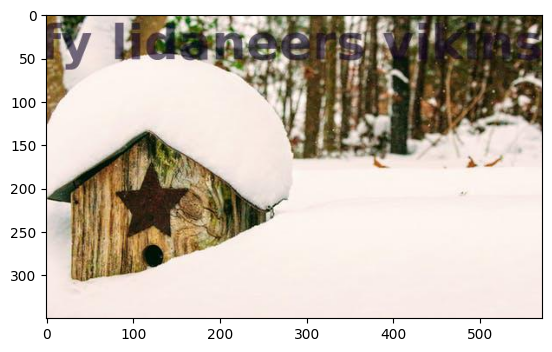

First 10 patch:


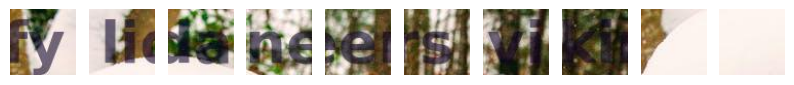

In [79]:
def generate_img_patch(img, crop_size):
    patches = []
    height, width = img.size()[1], img.size()[2] # channel_size, h, w

    for i in range(0, height, crop_size):
        for j in range(0, width, crop_size):
            if i + crop_size <= height and j + crop_size <= width:        
                cropped_part = img[:, i:i+crop_size, j:j+crop_size]
                patches.append(cropped_part)        
    
    return patches

img = Image.open(watermark_paths[0])
img = ToTensor()(img)

crop_size = 64
patches = generate_img_patch(img, crop_size)

plt.imshow(ToPILImage()(img).convert("RGB"))
plt.show()

num_patches_to_display = 10
print(f"First {num_patches_to_display} patch:")
fig, axs = plt.subplots(1, num_patches_to_display, figsize=(10, 10))

for i in range(num_patches_to_display):
    patch = ToPILImage()(patches[i]).convert("RGB")  # Convert the tensor patch to a PIL Image
    axs[i].imshow(patch)
    axs[i].axis('off')

plt.show()

In [117]:
class CustomDataset(Dataset):
    def __init__(self, watermark_paths, nowatermark_paths, crop_size, normalize=False):
        self.watermark_paths = watermark_paths
        self.nowatermark_paths = nowatermark_paths
        
        self.crop_size = crop_size
        self.normalize = normalize
        
    def __len__(self):
        return len(self.watermark_paths)
    
    def __getitem__(self, idx):
        inp_img = ToTensor()(Image.open(self.watermark_paths[idx]))
        target_img = ToTensor()(Image.open(self.nowatermark_paths[idx]))
        
        if self.normalize:
            inp_img = Normalize(((0.5,), (0.5, )))(inp_img)
            target_img = Normalize(((0.5,), (0.5, )))(target_img)
            
        input_patches = generate_img_patch(inp_img, self.crop_size)
        target_patches = generate_img_patch(target_img, self.crop_size)
        
        return {
            "inp": input_patches,
            "target": target_patches
        }
    
train_size, val_size = int(len(dataset)*0.6), int(len(dataset)*0.2)
test_size = len(dataset) - train_size - val_size 

dataset = CustomDataset(watermark_paths, nowatermark_paths, 64)
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

len(train_set), len(val_set), len(test_set)

(7506, 2502, 2502)

In [134]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1) # 62x62
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1) # 60x60
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1) # 58x58
        
        # Bottleneck
        self.mu = nn.Linear(58*58*128, latent_dim)
        self.var = nn.Linear(58*58*128, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 58*58*128)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1)  # 60x60
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)  # 62x62
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1)  # 64x64
               
    def reparameterize(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        
        return mu + eps * std
        
    def forward(self, x):
        # encoder
        x = self.dropout(self.relu(self.conv1(x)))
        x = self.dropout(self.relu(self.conv2(x)))
        x = self.dropout(self.relu(self.conv3(x))) # batchx128x58x58
        
        # bottleneck
        x = x.view(x.size(0), -1) # flatten 
        mu = self.mu(x)
        var = self.var(x)
        z = self.reparameterize(mu, var) # batchxlatent_dim
        
        # decoder
        x = self.fc_decoder(z)
        x = x.view(x.size(0), 128, 58, 58)
        x = self.dropout(self.relu(self.deconv1(x)))
        x = self.dropout(self.relu(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))
        
        return x, mu, var
    
x = torch.Tensor(np.zeros((3, 64, 64))).to(DEVICE)
model = VAE(latent_dim=128).to(DEVICE)
x, mu, var = model(x.unsqueeze(0))
print(x.size())

torch.Size([1, 3, 64, 64])


In [ ]:
NUM_EPOCHS = 10
LR_RATE = 0.0003

model = VAE(latent_dim=128).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.MSELoss(reduction='sum')

for _, i in enumerate(train_loader):
    optimizer.zero_grad()
    
    inp = i['inp']
    target = i['target']
    
    patch_loss = 0
    for p_id, patch in tqdm(enumerate(inp)):
        x, mu, var = model(patch)
        target_p = target[p_id] 
        
        loss = loss_fn(x, target_p)
        patch_loss += loss.item()
        
        loss.backward()
        optimizer.step()